In [ ]:
relu = 'relu'
selu = 'selu'
cls_num = 11
between_cls_num = 4
psk_cls_num, qam_cls_num, fsk_cls_num = 3,3,3

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def vgg():
    inp = Input([2, 128, 1]) # 1024
    out = Conv2D(64, kernel_size=(1,4), padding='same', kernel_initializer='he_normal', activation=None)(inp)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D(pool_size=(1,2), padding='same')(out) # 512
    
    out = Conv2D(64, kernel_size=(1,4), padding='same',kernel_initializer='he_normal', activation=None)(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D(pool_size=(1,2), padding='same')(out) # 256
    
    out = Conv2D(64, kernel_size=(2,1), padding='valid',kernel_initializer='he_normal', activation=None)(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D(pool_size=(1,2), padding='same')(out) # 128
    
    out = Conv2D(64, kernel_size=(1,4), padding='same',kernel_initializer='he_normal', activation=None)(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D(pool_size=(1,2), padding='same')(out) # 64
    
    out = Conv2D(64, kernel_size=(1,4), padding='same',kernel_initializer='he_normal', activation=None)(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D(pool_size=(1,2), padding='same')(out) # 32
    
    out = Conv2D(64, kernel_size=(1,4), padding='same',kernel_initializer='he_normal', activation=None)(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D(pool_size=(1,2), padding='same')(out) # 16
    
    out = Conv2D(64, kernel_size=(1,4), padding='same',kernel_initializer='he_normal', activation=None)(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D(pool_size=(1,2), padding='same')(out) # 8       
    
    out = Flatten()(out)
    out = Dense(256, activation='selu', kernel_initializer='he_normal')(out)
    out = Dense(256, activation='selu', kernel_initializer='he_normal')(out)
    out = Dense(11, activation='softmax', kernel_initializer='he_normal')(out)
    return Model(inputs=inp, outputs=out)


In [ ]:
def bottleneck_block(inp, kernel_size=(1,4), filters=[16,16,32], name='bottleneck_block'):
    out = Conv2D(filters[0], kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal', 
                 name=name+'_conv_1', padding='same', activation=None)(inp)
    out = BatchNormalization()(out)
    out = Activation(relu)(out)

    out = Conv2D(filters[1], kernel_size=kernel_size, strides=(1,1), kernel_initializer='he_normal', 
                 name=name+'_conv_2', padding='same', activation=None)(out)
    out = BatchNormalization()(out)
    out = Activation(relu)(out)
    
    out = Conv2D(filters[2], kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal', 
                 name=name+'_conv_3', padding='same', activation=None)(out)
    out = BatchNormalization()(out)    
    
    
    out = add([out, inp])
    out = Activation(relu)(out)
    return out

In [ ]:
def resnet_26():
    inp = Input([2, 128, 1]) # 1024
    # stage 0
    out = Conv2D(64, (1,4), padding='same', kernel_initializer='he_normal', activation=None, name='s0')(inp)
    out = BatchNormalization()(out)
    out = Activation(relu)(out) # 1024
    
    # stage 1
    out = bottleneck_block(out, kernel_size=(1,4), filters=[16,16,64], name='s1_block_1')
    out = bottleneck_block(out, kernel_size=(1,4), filters=[16,16,64], name='s1_block_2')
    out = MaxPooling2D(pool_size=(1,2), padding='same')(out) # 512
    # stage 2
    out = bottleneck_block(out, kernel_size=(1,4), filters=[16,16,64], name='s2_block_1')
    out = bottleneck_block(out, kernel_size=(1,4), filters=[16,16,64], name='s2_block_2')
    out = MaxPooling2D(pool_size=(1,2), padding='same')(out) # 256
    # stage 3
    out = Conv2D(64, (2,3), padding='valid', kernel_initializer='he_normal', activation=None, name='s3')(out)
    out = BatchNormalization()(out)
    out = Activation(relu)(out)
    out = MaxPooling2D(pool_size=(1,2), padding='same')(out) # 127
    # stage 4
    out = bottleneck_block(out, kernel_size=(1,4), filters=[16,16,64], name='s4_block_1')
    out = bottleneck_block(out, kernel_size=(1,4), filters=[16,16,64], name='s4_block_2')
    out = MaxPooling2D(pool_size=(1,2), padding='same')(out) # 64
    # stage 5
    out = bottleneck_block(out, kernel_size=(1,4), filters=[16,16,64], name='s5_block_1')
    out = bottleneck_block(out, kernel_size=(1,4), filters=[16,16,64], name='s5_block_2')
    out = MaxPooling2D(pool_size=(1,2), padding='same')(out) # 32
    
    # stage 6
    out = GlobalAveragePooling2D()(out)
    out = Dense(cls_num, kernel_initializer='he_normal', activation='softmax', name='output')(out)
    return Model(inputs=inp, outputs=out)

In [ ]:
import numpy as np # linear algebra
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, Input, Lambda, MaxPooling2D, BatchNormalization, Activation, add, advanced_activations, Dense, Flatten, GlobalAveragePooling2D, Dropout

#from keras import backend as K
from keras.layers.merge import concatenate
from keras.initializers import glorot_normal, glorot_uniform, he_normal, he_uniform
from keras.models import Model, load_model
from keras.models import Sequential
import keras.models as models
# import modules
from IPython.display import display, clear_output
import numpy as np
import os
# import deep learning libraries
import os
import keras
import pickle
from keras import layers
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.layers import Input, Dropout, Add, Dense, Reshape, Activation
from keras.layers import BatchNormalization, Flatten, Conv1D, MaxPooling1D

import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
from tensorflow.keras import layers
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from tensorflow.python.keras.optimizer_v2.adam import Adam
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pickle, random, sys, keras
import h5py

In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#De-Pickling Data with encoding latin1
with open("/content/drive/My Drive/Colab Notebooks/UGP_data/RML2016.10a_dict.pickle", 'rb') as f:
    Xd = pickle.load(f, encoding='latin1')

In [ ]:
classes = ['32PSK', '16APSK', '32QAM', 'FM', 'GMSK', '32APSK', 'OQPSK', #1
 '8ASK', 'BPSK','8PSK', 'AM-SSB-SC', '4ASK', '16PSK', '64APSK', '128QAM', '128APSK','AM-DSB-SC', #2 
'AM-SSB-WC', '64QAM', 'QPSK', '256QAM','AM-DSB-WC','OOK','16QAM']

In [ ]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [ ]:
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

In [ ]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [ ]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [ ]:
nb_epoch = 50    # number of epochs to train on
batch_size = 1024  # training batch size
dr = 0.5 # dropout rate (%)

In [ ]:
model = models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(vgg())
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 2, 128, 1)         0         
_________________________________________________________________
model_9 (Functional)         (None, 11)                177867    
Total params: 177,867
Trainable params: 176,971
Non-trainable params: 896
_________________________________________________________________


In [ ]:
m = models.Sequential()
m.add(Reshape(in_shp+[1], input_shape=in_shp))
m.add(resnet_26())
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
m.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_11 (Reshape)         (None, 2, 128, 1)         0         
_________________________________________________________________
model_10 (Functional)        (None, 11)                54603     
Total params: 54,603
Trainable params: 52,811
Non-trainable params: 1,792
_________________________________________________________________


In [ ]:
filepath = 'weight_4layers.wts.h5'
history = model.fit(
    X_train, Y_train,
    batch_size=batch_size, epochs=nb_epoch,
    verbose=1, validation_data=(X_test, Y_test),
    callbacks = [keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
                 keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

Epoch 1/50
108/108 [==============================] - 5s 42ms/step - loss: 2.0560 - accuracy: 0.3016 - val_loss: 6.0330 - val_accuracy: 0.0916
Epoch 2/50
108/108 [==============================] - 4s 40ms/step - loss: 1.3131 - accuracy: 0.4979 - val_loss: 4.5435 - val_accuracy: 0.0908
Epoch 3/50
108/108 [==============================] - 4s 40ms/step - loss: 1.2442 - accuracy: 0.5244 - val_loss: 3.7681 - val_accuracy: 0.0892
Epoch 4/50
108/108 [==============================] - 4s 40ms/step - loss: 1.2080 - accuracy: 0.5399 - val_loss: 3.6438 - val_accuracy: 0.0842
Epoch 5/50
108/108 [==============================] - 4s 40ms/step - loss: 1.1730 - accuracy: 0.5480 - val_loss: 3.1145 - val_accuracy: 0.1117
Epoch 6/50
108/108 [==============================] - 4s 40ms/step - loss: 1.1534 - accuracy: 0.5596 - val_loss: 3.4068 - val_accuracy: 0.2001
Epoch 7/50
108/108 [==============================] - 4s 40ms/step - loss: 1.1409 - accuracy: 0.5619 - val_loss: 2.4685 - val_accuracy: 0.2984

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=1, batch_size=batch_size)
print("Validation Loss and Accuracy: ",score)

108/108 [==============================] - 1s 10ms/step - loss: 2.1600 - accuracy: 0.3784
Validation Loss and Accuracy:  [2.160013437271118, 0.3784181773662567]


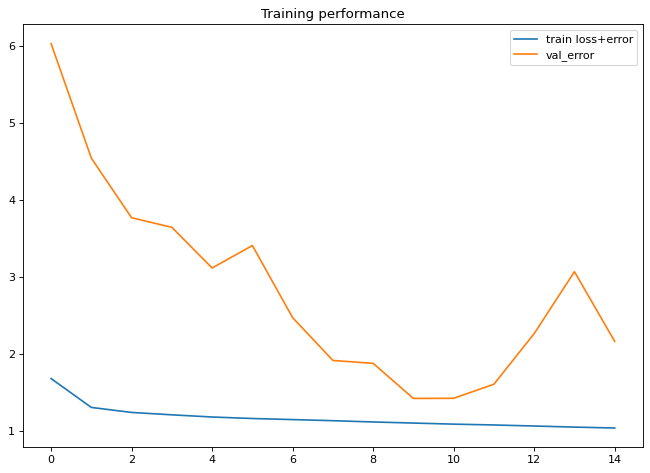

In [ ]:
figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='black')
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.show()

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

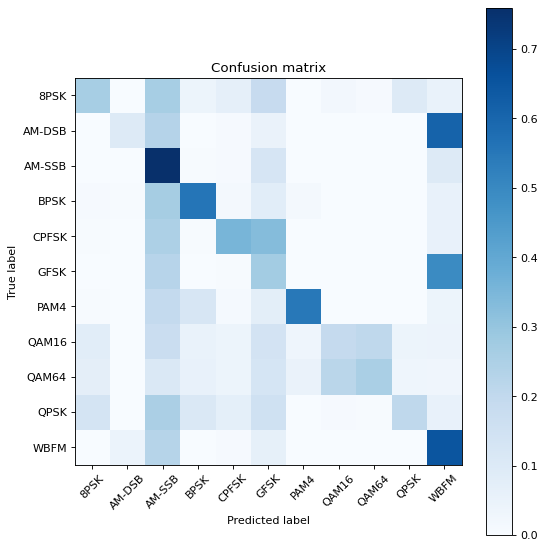

In [ ]:
figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='black')
plot_confusion_matrix(confnorm, labels=classes)

In [ ]:
acc = {}
for snr in snrs:
  # extract classes @ SNR
  test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
  test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
  test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]
  # estimate classes
  test_Y_i_hat = model.predict(test_X_i)
  conf = np.zeros([len(classes),len(classes)])
  confnorm = np.zeros([len(classes),len(classes)])
  for i in range(0,test_X_i.shape[0]):
    j = list(test_Y_i[i,:]).index(1)
    k = int(np.argmax(test_Y_i_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

  for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

  #plt.figure()
  #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
  cor = np.sum(np.diag(conf))
  ncor = np.sum(conf) - cor
  print("SNR: ",snr, " Overall Accuracy: ", cor / (cor + ncor))
  acc[snr] = 1.0 * cor / (cor + ncor)

SNR:  -20  Overall Accuracy:  0.0909423604757548
SNR:  -18  Overall Accuracy:  0.08919164396003633
SNR:  -16  Overall Accuracy:  0.0917149059334298
SNR:  -14  Overall Accuracy:  0.09094189823168532
SNR:  -12  Overall Accuracy:  0.09735642661804922
SNR:  -10  Overall Accuracy:  0.13079793851075172
SNR:  -8  Overall Accuracy:  0.19254087819217344
SNR:  -6  Overall Accuracy:  0.2862903225806452
SNR:  -4  Overall Accuracy:  0.3822550831792976
SNR:  -2  Overall Accuracy:  0.4972786647314949
SNR:  0  Overall Accuracy:  0.5432481751824818
SNR:  2  Overall Accuracy:  0.5557978916757542
SNR:  4  Overall Accuracy:  0.5574522760646109
SNR:  6  Overall Accuracy:  0.5711191335740072
SNR:  8  Overall Accuracy:  0.5648331830477908
SNR:  10  Overall Accuracy:  0.5642987249544626
SNR:  12  Overall Accuracy:  0.5707043273583198
SNR:  14  Overall Accuracy:  0.5761210555453036
SNR:  16  Overall Accuracy:  0.5641628959276018
SNR:  18  Overall Accuracy:  0.5546354635463546


{-20: 0.0909423604757548, -18: 0.08919164396003633, -16: 0.0917149059334298, -14: 0.09094189823168532, -12: 0.09735642661804922, -10: 0.13079793851075172, -8: 0.19254087819217344, -6: 0.2862903225806452, -4: 0.3822550831792976, -2: 0.4972786647314949, 0: 0.5432481751824818, 2: 0.5557978916757542, 4: 0.5574522760646109, 6: 0.5711191335740072, 8: 0.5648331830477908, 10: 0.5642987249544626, 12: 0.5707043273583198, 14: 0.5761210555453036, 16: 0.5641628959276018, 18: 0.5546354635463546}


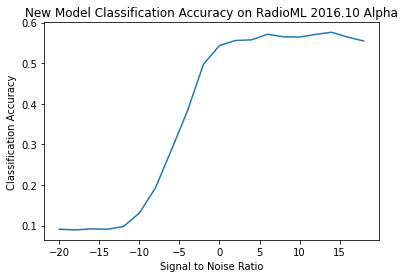

In [ ]:
print(acc)
fd = open('results_cnn_d0.5.dat','wb')
pickle.dump( ("CNN", 0.5, acc) , fd )

# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("New Model Classification Accuracy on RadioML 2016.10 Alpha")
plt.show()

In [ ]:
filepath = 'weight_4layers.wts.h5'
history = m.fit(
    X_train, Y_train,
    batch_size=batch_size, epochs=nb_epoch,
    verbose=1, validation_data=(X_test, Y_test),
    callbacks = [keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
                 keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

Epoch 1/50
108/108 [==============================] - 13s 95ms/step - loss: 2.7048 - accuracy: 0.2379 - val_loss: 4.0328 - val_accuracy: 0.0896
Epoch 2/50
108/108 [==============================] - 10s 91ms/step - loss: 1.5496 - accuracy: 0.4258 - val_loss: 7.7180 - val_accuracy: 0.0882
Epoch 3/50
108/108 [==============================] - 10s 92ms/step - loss: 1.3928 - accuracy: 0.4768 - val_loss: 9.3691 - val_accuracy: 0.0916
Epoch 4/50
108/108 [==============================] - 10s 93ms/step - loss: 1.3171 - accuracy: 0.5064 - val_loss: 8.2110 - val_accuracy: 0.0927
Epoch 5/50
108/108 [==============================] - 10s 92ms/step - loss: 1.2778 - accuracy: 0.5213 - val_loss: 5.1899 - val_accuracy: 0.1052
Epoch 6/50
108/108 [==============================] - 10s 92ms/step - loss: 1.2388 - accuracy: 0.5371 - val_loss: 2.7776 - val_accuracy: 0.2126
Epoch 7/50
108/108 [==============================] - 10s 91ms/step - loss: 1.2128 - accuracy: 0.5476 - val_loss: 1.8821 - val_accuracy:

In [ ]:
score = m.evaluate(X_test, Y_test, verbose=1, batch_size=batch_size)
print("Validation Loss and Accuracy: ",score)

108/108 [==============================] - 2s 21ms/step - loss: 1.3522 - accuracy: 0.4855
Validation Loss and Accuracy:  [1.352196216583252, 0.48550909757614136]


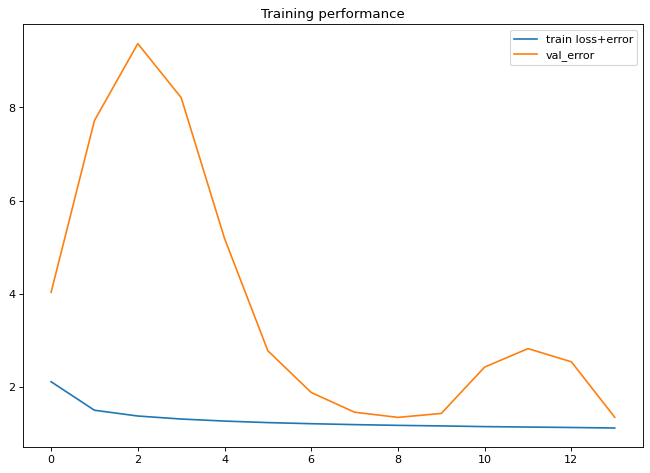

In [ ]:
figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='black')
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.show()

In [ ]:
test_Y_hat = m.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

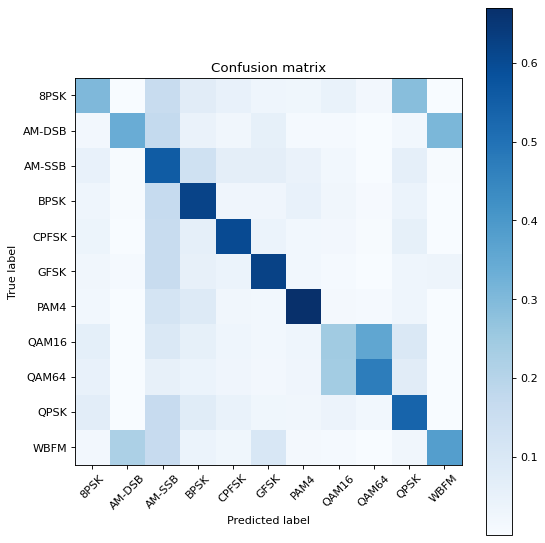

In [ ]:
figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='black')
plot_confusion_matrix(confnorm, labels=classes)

In [ ]:
acc = {}
for snr in snrs:
  # extract classes @ SNR
  test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
  test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
  test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]
  # estimate classes
  test_Y_i_hat = m.predict(test_X_i)
  conf = np.zeros([len(classes),len(classes)])
  confnorm = np.zeros([len(classes),len(classes)])
  for i in range(0,test_X_i.shape[0]):
    j = list(test_Y_i[i,:]).index(1)
    k = int(np.argmax(test_Y_i_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

  for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

  #plt.figure()
  #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
  cor = np.sum(np.diag(conf))
  ncor = np.sum(conf) - cor
  print("SNR: ",snr, " Overall Accuracy: ", cor / (cor + ncor))
  acc[snr] = 1.0 * cor / (cor + ncor)

SNR:  -20  Overall Accuracy:  0.09734675205855443
SNR:  -18  Overall Accuracy:  0.0930063578564941
SNR:  -16  Overall Accuracy:  0.09533285094066571
SNR:  -14  Overall Accuracy:  0.10627932154456875
SNR:  -12  Overall Accuracy:  0.1365542388331814
SNR:  -10  Overall Accuracy:  0.2025946330193709
SNR:  -8  Overall Accuracy:  0.2818298732316737
SNR:  -6  Overall Accuracy:  0.3880131964809384
SNR:  -4  Overall Accuracy:  0.49001848428835487
SNR:  -2  Overall Accuracy:  0.6115747460087083
SNR:  0  Overall Accuracy:  0.67007299270073
SNR:  2  Overall Accuracy:  0.693384223918575
SNR:  4  Overall Accuracy:  0.7184287812041116
SNR:  6  Overall Accuracy:  0.7362815884476535
SNR:  8  Overall Accuracy:  0.7284039675383228
SNR:  10  Overall Accuracy:  0.741712204007286
SNR:  12  Overall Accuracy:  0.730581205866377
SNR:  14  Overall Accuracy:  0.7383281048163868
SNR:  16  Overall Accuracy:  0.7250678733031675
SNR:  18  Overall Accuracy:  0.7292529252925293


{-20: 0.09734675205855443, -18: 0.0930063578564941, -16: 0.09533285094066571, -14: 0.10627932154456875, -12: 0.1365542388331814, -10: 0.2025946330193709, -8: 0.2818298732316737, -6: 0.3880131964809384, -4: 0.49001848428835487, -2: 0.6115747460087083, 0: 0.67007299270073, 2: 0.693384223918575, 4: 0.7184287812041116, 6: 0.7362815884476535, 8: 0.7284039675383228, 10: 0.741712204007286, 12: 0.730581205866377, 14: 0.7383281048163868, 16: 0.7250678733031675, 18: 0.7292529252925293}


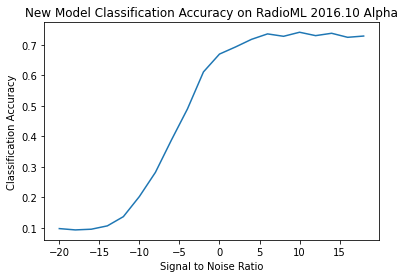

In [ ]:
print(acc)
fd = open('results_cnn_d0.5.dat','wb')
pickle.dump( ("CNN", 0.5, acc) , fd )

# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("New Model Classification Accuracy on RadioML 2016.10 Alpha")
plt.show()